# Identifying candidate markers for isolation of neuron-specific extracellular vesicles 

This notebook will reproduce the figures in Ter-Ovanesyan et al that relate to identifying candidate markers for neuron-specific EV isolation. 

Before running the notebook, please confirm that you have cloned the repository properly and have the required python packages. By clicking "run all", the notebook should reproduce the data shown in Figure 2 and S1 in the 'figures' directory and produce the supplemental tables in the 'supp_tables' directory.

In [1]:
#setup wrapper functions
from setup import setup_datasets
from tau_calculations import make_taus
from tau_calculations import count_gene_categories
from tau_calculations import make_unified_gene_list,unify_tau_dataframes
from intersect_genes import scatterplot_tau, cutoff_heatmap
from intersect_genes import get_specific_tau, get_final_list
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
from intersect_genes import myplot
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams["font.family"] = "Arial"

brain_cell_type = 'neurons'
organ_type = 'Brain'
all_data = setup_datasets(brain_cell_type, organ_type)

Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 66298.47it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!


## Figure 2B: Mass Spectrometry Dataset Metrics

In [2]:
running_list = []
for i in [0,1]:
    total = len(all_data['mass_spec'][i])
    TMU = sum([u in all_data['allTMU'] for u in all_data['mass_spec'][i]])
    print('{} total proteins and {} transmembrane proteins in {}'.format(total,
                                                                     TMU,
                                                                     all_data['mass_spec_names'][i]))
    running_list += all_data['mass_spec'][i]
print('Total number between both:', len(set(running_list)))

1862 total proteins and 328 transmembrane proteins in DT Mass Spec - Plasma
2104 total proteins and 452 transmembrane proteins in DT Mass Spec - CSF
Total number between both: 2842


In [3]:
all_data = make_taus(all_data, show_plots = False)
all_data = make_unified_gene_list(all_data)

Creating unified gene lists...
Done!


## Figure 2D:

2d histogram of tau values for all TMU proteins

Unifying tau values into a single matrix...


4925it [00:00, 9723.34it/s]


Done!


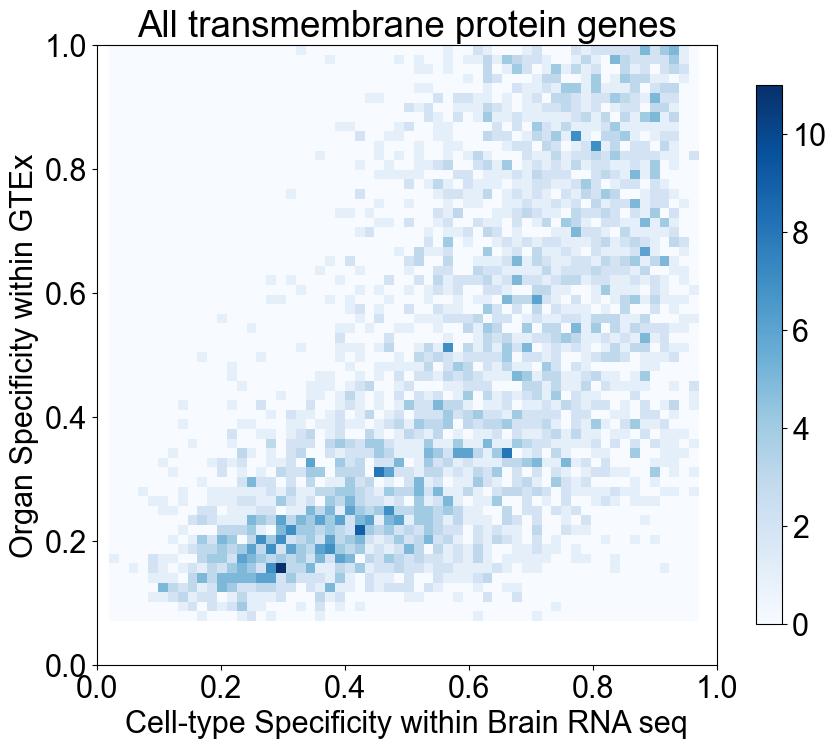

In [4]:
plt.rcParams.update({'font.size': 22})
all_data = unify_tau_dataframes(all_data, all_data['full_uniprots_TMU'])
plotting_df = all_data['master_tau_df'][['Brain_RNA-Seq', 'GTEx']]
plotting_df = plotting_df.loc[~(plotting_df==0).any(axis=1)]

heatmap, extent = myplot(plotting_df['Brain_RNA-Seq'],
                                     plotting_df['GTEx'], s= 0.8, bins = 60)
plt.figure(figsize = (10,10))
plt.imshow(heatmap, extent = extent, origin = 'lower', cmap = cm.Blues)
plt.colorbar(shrink = 0.7)
plt.ylabel('Organ Specificity within GTEx')
plt.xlabel('Cell-type Specificity within Brain RNA seq')
plt.title('All transmembrane protein genes')
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig('../figures/figure_2d_2dhistogram.pdf', transparent = True, dpi = 600)

## Figure 2D: 

scatterplot of tau values for TMU with max in brain/neurons

Unifying tau values into a single matrix...


291it [00:00, 9052.45it/s]

Done!
Total number of transmembrane genes which are more in neurons and more in the brain: 291


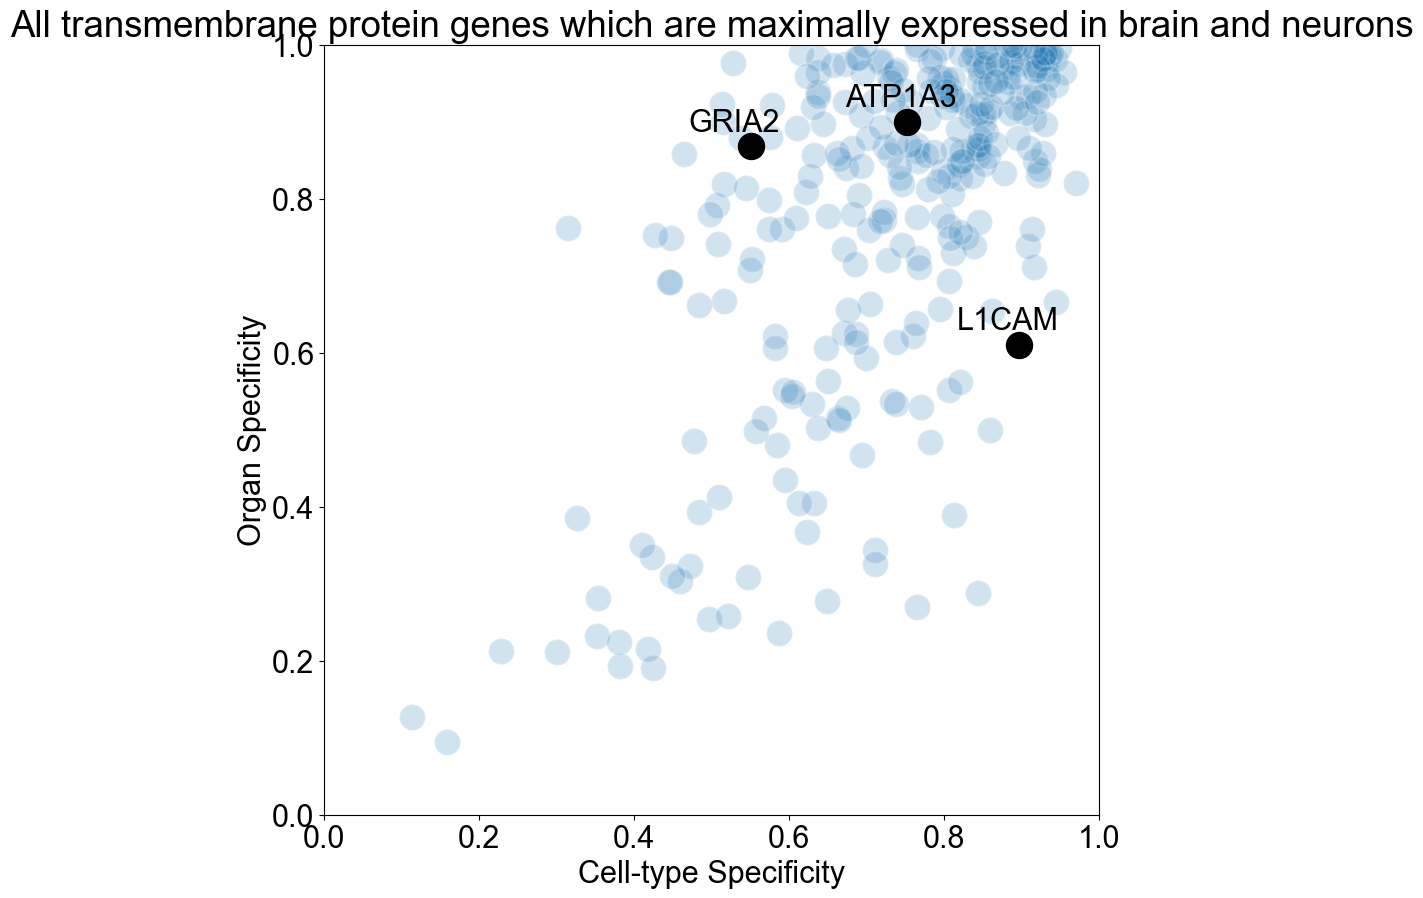

In [5]:
import seaborn as sns
import numpy as np
all_data = unify_tau_dataframes(all_data, all_data['max_uniprots_TMU'])
plotting_df = all_data['master_tau_df'][['Brain_RNA-Seq', 'GTEx']]
plotting_df = plotting_df.loc[~(plotting_df==0).any(axis=1)]
plotted_uniprots = [u for u,g in plotting_df.index]
plt.figure(figsize = (10,10))
sns.scatterplot(x = 'Brain_RNA-Seq', y = 'GTEx',
                alpha = 0.2*np.log(plotting_df.shape[0]) / np.log(plotting_df.shape[0]),
                s= 350, 
                data = plotting_df)  
print('Total number of transmembrane genes which are more in neurons and more in the brain: {}'.format(all_data['master_tau_df'].shape[0]))
plt.ylabel('Organ Specificity')
plt.xlabel('Cell-type Specificity')
plt.title('All transmembrane protein genes which are maximally expressed in brain and neurons')
plt.xlim((0,1))
plt.ylim((0,1))   
                                                   
                                                   
to_denote = ['L1CAM', 'GRIA2', 'NCAM1', 'ATP1A3']
                                                   
denoted_u = []
denoted_g = []
g2u = all_data['g2u']
oldg2u = all_data['oldg2u']
for g in to_denote:
    if g in g2u:
        denoted_u.append(g2u[g])
        denoted_g.append(g)
    elif g in oldg2u:
        denoted_u.append(oldg2u[g])
        denoted_g.append(g)
    else:
        print('Can\'t denote {} in scatterplot, no matching uniprot for this name'.format(g))                                                  

for i, uniprot in enumerate(plotted_uniprots):
    if uniprot in denoted_u:
        gene_name = denoted_g[denoted_u.index(uniprot)]
        plt.scatter(plotting_df.iloc[i][0],plotting_df.iloc[i][1], c = 'k', 
                    s = 350, alpha= 1)
        plt.annotate(gene_name, (plotting_df.iloc[i][0]-0.08,plotting_df.iloc[i][1]+0.02),
                     c = 'k')
        
plt.savefig('../figures/figure_2e_scatterplot_brainneuronmax.pdf', transparent = True, dpi = 600)

## Figure 2E:
Human Transmembrane proteins with brain/neuron specific expression

In [6]:
from surface_marker_utils import intersection
tmu_specific_lists = []
for i in [0,1]:
    df = all_data['max_tau_dfs'][i]
    specific = df[df['Tau']> 0.7]
    print('Specific proteins in {}: {}'.format(all_data['gene_exp_df_names'][i],specific.shape[0]))
    tmu_specific_list= []
    for u in specific['Gene']:
        if u in all_data['allTMU']:
            tmu_specific_list.append(u)
    tmu_specific_lists.append(tmu_specific_list)
    print('{} transmembrane proteins with specific expression in {}'.format(len(tmu_specific_list),
                                                                            all_data['gene_exp_df_names'][i]))

bispecific_list = intersection(tmu_specific_lists[0],tmu_specific_lists[1])
print('{} transmembrane proteins with specific expression in both'.format(len(bispecific_list)))

Specific proteins in GTEx: 945
417 transmembrane proteins with specific expression in GTEx
Specific proteins in Brain_RNA-Seq: 1125
426 transmembrane proteins with specific expression in Brain_RNA-Seq
165 transmembrane proteins with specific expression in both


## Figure 2F
sCimilarity histogram

Neuron-specific genes by sCimilarity: 405
Neuron-specific by sCimilarity and TMU genes: 179


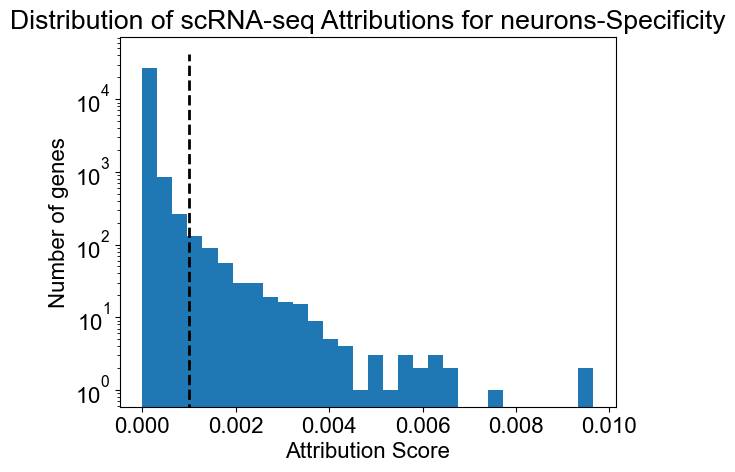

In [7]:
plt.rcParams.update({'font.size': 16})
plt.figure()
plt.title('Distribution of scRNA-seq Attributions for {}-Specificity'.format(brain_cell_type))
plt.xlabel('Attribution Score')
plt.ylabel('Number of genes')
plt.hist(all_data['scRNA_data']['attribution'], bins = 30)
# plt.ylim(top = 4.2e4)
plt.plot([0.001, 0.001], [0,4.2e4], color='black', linestyle='dashed', linewidth=2, markersize=12)
plt.yscale('log')
plt.savefig('../figures/figure_2F.pdf'.format(brain_cell_type),
            bbox_inches = 'tight', transparent = True, dpi = 300)
print('Neuron-specific genes by sCimilarity: {}'.format(sum(all_data['scRNA_data']['attribution']>0.001)))

scimilarity_genes= all_data['scRNA_data'][all_data['scRNA_data']['attribution']>0.001]['gene']

scimilarity_uniprots = []
for g in scimilarity_genes:
    if g in all_data['g2u']:
        scimilarity_uniprots.append(all_data['g2u'][g])
    elif g in all_data['oldg2u']:
        scimilarity_uniprots.append(all_data['oldg2u'][g])
    else:
        scimilarity_uniprots.append('null') 

print('Neuron-specific by sCimilarity and TMU genes: {}'.format(len(intersection(scimilarity_uniprots, all_data['allTMU']))))

## Figure 2H

Venn Diagram from bulk RNA seq

In [8]:
plt.rcParams.update({'font.size': 8})
print('\n{} total TMU proteins'.format(len(all_data['allTMU'])))

mass_spec_total = set(list(all_data['mass_spec'][0]) + list(all_data['mass_spec'][1]))
print('\n{} total mass-spectrometry detected proteins in CSF or plasma EVs'.format(len(mass_spec_total)))

all_data = unify_tau_dataframes(all_data, all_data['max_uniprots'])
master_tau_df = all_data['master_tau_df']
c = 0
for gtex, brs in zip(master_tau_df['GTEx'], master_tau_df['Brain_RNA-Seq']):
    if gtex > 0.7 and brs > 0.7:
        c += 1
print('\n{} total neuron AND brain-specific genes'.format(c))
all_data = unify_tau_dataframes(all_data, all_data['max_uniprots_TMU'])
all_data = get_specific_tau(all_data, 
                                 organ_tau_cutoff = 0.7,
                                  cell_tau_cutoff = 0.7,
                                 cluster_tau = False)

all_data = get_final_list(all_data, exp_name = '20230730', topk= 20, use_scimilarity = False)
candidates = all_data['candidates']
candidate_uniprots = [u for u,g in candidates.index]
bulk_candidate_uniprots = candidate_uniprots


print('\nTotal candidates before mass-spec filtering: {}'.format(len(bulk_candidate_uniprots)))

ips_overlap = intersection(bulk_candidate_uniprots, all_data['mass_spec'][2])
print('\nOverlap of bulk candidate uniprots with iPS neuron-ev mass spec: {}'.format(len(ips_overlap)))
mass_spec_sum = candidates['DT Mass Spec - Plasma'] + candidates['DT Mass Spec - CSF']

bulk_candidates = []
for i,s in enumerate(mass_spec_sum):
    if s > 0:
        bulk_candidates.append(candidate_uniprots[i])
print('\n{} Total Candidate Markers from Bulk RNA Seq'.format(len(bulk_candidates)))
for c in bulk_candidates:
    print(all_data['u2g'][c])


5196 total TMU proteins

2842 total mass-spectrometry detected proteins in CSF or plasma EVs
Unifying tau values into a single matrix...


783it [00:00, 9182.84it/s]


Done!

344 total neuron AND brain-specific genes
Unifying tau values into a single matrix...


291it [00:00, 9304.90it/s]

Done!

Total candidates before mass-spec filtering: 165

Overlap of bulk candidate uniprots with iPS neuron-ev mass spec: 11

28 Total Candidate Markers from Bulk RNA Seq
GRM7
ADGRA1
SLC32A1
SVOP
GABRB3
CHRNB2
SLC6A17
PLPPR4
C11orf87
PTPRT
GRM8
PTPRR
SLC12A5
SORCS3
CALY
KIAA1549L
HCN1
TMEM132D
CDH18
FRRS1L
GPR158
GRIA4
ST8SIA3
PCDHAC2
HS6ST3
ATP2B3
SEZ6
NRXN3


## Figure 2H

Venn Diagram from single-cell RNA seq

In [9]:
print('{} total TMU proteins'.format(len(all_data['allTMU'])))

mass_spec_total = set(list(all_data['mass_spec'][0]) + list(all_data['mass_spec'][1]))
print('{} total mass-spectrometry detected proteins in CSF or plasma EVs'.format(len(mass_spec_total)))

print('Neuron-specific genes by sCimilarity: {}'.format(sum(all_data['scRNA_data']['attribution']>0.001)))


all_data = get_final_list(all_data, exp_name = '20230730', topk= 20, use_scimilarity = True)
candidates = all_data['candidates']
print('Neuron-specific genes with TM domains by sCimilarity:', sum(candidates['Transmembrane']))
mass_spec_sum = candidates['DT Mass Spec - Plasma'] + candidates['DT Mass Spec - CSF']
candidate_uniprots = []
for g in candidates.index:
    if g in all_data['g2u']:
        candidate_uniprots.append(all_data['g2u'][g])
    elif g in all_data['oldg2u']:
        candidate_uniprots.append(all_data['oldg2u'][g])
    else:
        candidate_uniprots.append('null')
sc_candidate_uniprots = candidate_uniprots

sc_candidates = []
for i,s in enumerate(mass_spec_sum):
    if s > 0:
        sc_candidates.append(candidate_uniprots[i])
print('{} Total Candidate Markers from single-cell RNA Seq'.format(len(sc_candidates)))

5196 total TMU proteins
2842 total mass-spectrometry detected proteins in CSF or plasma EVs
Neuron-specific genes by sCimilarity: 405
Neuron-specific genes with TM domains by sCimilarity: 179
77 Total Candidate Markers from single-cell RNA Seq


## Figure 2J

Intersection between bulk and single-cell candidates

In [10]:
best = intersection(bulk_candidates, sc_candidates)
print(len(best))
for b in best:
    print(all_data['u2g'][b])

13
GRM7
GABRB3
PTPRR
CALY
KIAA1549L
HCN1
TMEM132D
CDH18
FRRS1L
GPR158
GRIA4
HS6ST3
NRXN3


## Various text numbers


In [11]:
all_data = unify_tau_dataframes(all_data, all_data['max_uniprots'])
master_tau_df = all_data['master_tau_df']
all_data = get_specific_tau(all_data, 
                                 organ_tau_cutoff = 0.7,
                                  cell_tau_cutoff = 0.7,
                                 cluster_tau = False)

all_data = get_final_list(all_data, exp_name = '20230730', topk= 20, use_scimilarity = False, show_heatmap = False)

print('Number of proteins that are brain+neuron specific by bulk RNA seq AND neuron specific by sCimilarity: {}'.format(sum(all_data['candidates']['scRNAseq Attribution'] > 0.001)))

all_data = unify_tau_dataframes(all_data, all_data['max_uniprots_TMU'])
master_tau_df = all_data['master_tau_df']
all_data = get_specific_tau(all_data, 
                                 organ_tau_cutoff = 0.7,
                                  cell_tau_cutoff = 0.7,
                                 cluster_tau = False)

all_data = get_final_list(all_data, exp_name = '20230730', topk= 20, use_scimilarity = False, show_heatmap = False)
candidates = all_data['candidates']
candidate_uniprots = [u for u,g in candidates.index]
bulk_candidate_uniprots = candidate_uniprots

bulk_and_sc = intersection(bulk_candidate_uniprots, sc_candidate_uniprots)

print('\nNumber of transmembrane proteins that are brain+neuron specific by bulk RNA seq AND neuron specific by sCimilarity: {}'.format(len(bulk_and_sc)))


annotations = pd.read_csv('../data/prot_ann/uniprot-organism_homo_sapiens.tab',  sep='\t',
                             low_memory = False)
human_annotations = annotations[annotations.Organism == 'Homo sapiens (Human)']

TMU = []
g2u = {}
reviewed = human_annotations[human_annotations['Status'] == 'reviewed']
print('Total number of reviewed proteins from uniprot:', reviewed.shape[0])
print('Total number of reviewed proteins with a transmembrane domain from uniprot:', len(all_data['allTMU']))

Unifying tau values into a single matrix...


783it [00:00, 9395.01it/s]


Done!
Number of proteins that are brain+neuron specific by bulk RNA seq AND neuron specific by sCimilarity: 113
Unifying tau values into a single matrix...


291it [00:00, 8796.58it/s]


Done!

Number of transmembrane proteins that are brain+neuron specific by bulk RNA seq AND neuron specific by sCimilarity: 63
Total number of reviewed proteins from uniprot: 20375
Total number of reviewed proteins with a transmembrane domain from uniprot: 5196


In [12]:
 len(all_data['mass_spec'][2])

197

## iPS Neuron mass-spec

Things that show up in iPS neuron mass-spec and are brain+neuron specific

In [13]:
ips_neuron_TMU = intersection(all_data['allTMU'], all_data['mass_spec'][2])
print('Transmembrane domain proteins detected in iPS neuron', len(ips_neuron_TMU))

i = 0
df = all_data['max_tau_dfs'][i]
specific = df[df['Tau']> 0.7]
ips_neuron_and_specific_gtex = intersection(list(specific['Gene']),all_data['mass_spec'][2])
print(len(list(specific['Gene'])))
print('Total proteins that are found in ips neuron mass spec and which are specific to {}: {}'.format(all_data['gene_exp_df_names'][i],
                                                                                                      len(ips_neuron_and_specific_gtex)))
i = 1
df = all_data['max_tau_dfs'][i]
specific = df[df['Tau']> 0.7]
ips_neuron_and_specific_brs = intersection(list(specific['Gene']),all_data['mass_spec'][2])
print(len(list(specific['Gene'])))
print('Total proteins that are found in ips neuron mass spec and which are specific to {}: {}'.format(all_data['gene_exp_df_names'][i],
                                                                                                      len(ips_neuron_and_specific_brs)))
for u in intersection(ips_neuron_and_specific_gtex, ips_neuron_and_specific_brs):
    print(all_data['u2g'][u])

Transmembrane domain proteins detected in iPS neuron 174
945
Total proteins that are found in ips neuron mass spec and which are specific to GTEx: 26
1125
Total proteins that are found in ips neuron mass spec and which are specific to Brain_RNA-Seq: 23
SYT2
SLC4A10
SCN3A
ATP2B2
CELSR3
GRIK2
PCLO
SYT1
ATP8A2
DISP2
SYP
ATP2B3


## Supplemental table S3: 

Tab1: List of all proteins which we annotate to have a transmembrane domain.

Tab2: list of all proteins which we annotate to be GPI anchored.

In [14]:
f = open('../supp_tables/table_s2_tmu.csv', 'w+')
f.write('Number,Gene Name\n')
for i, u in enumerate(all_data['allTMU']):
    if u in all_data['u2g']:
        f.write('{},{}\n'.format(i+1,all_data['u2g'][u]))
    elif u in all_data['oldu2g']:
        f.write('{},{}\n'.format(i+1,all_data['oldu2g'][u]))
    else:
        f.write('{},{}\n'.format(i+1,u))
f.close()



f = open('../supp_tables/table_s2_gpi.csv', 'w+')
f.write('Number,Gene Name\n')
for i, u in enumerate(all_data['GPI Uniprots']):
    if u in all_data['u2g']:
        f.write('{},{}\n'.format(i+1,all_data['u2g'][u]))
    elif u in all_data['oldu2g']:
        f.write('{},{}\n'.format(i+1,all_data['oldu2g'][u]))
    else:
        f.write('{},{}\n'.format(i+1,u))
f.close()

for file,name in zip(['../supp_tables/table_s2_tmu.csv',
                      '../supp_tables/table_s2_gpi.csv'],
                     ['Transmembrane','GPI']):
    dfs= []
    dfs.append(pd.read_csv(file))
    excel = '_'.join(file.split('_')[:-1]) + '.xlsx'
    
    with pd.ExcelWriter(excel) as writer: 
        df.to_excel(writer, sheet_name=name, index = False) 


## Making the other supplemental tables

### Supplemental table S4: 

All genes that are brain and brain-cell-type specific for neurons, astrocytes, microglia, oligodendrocytes, by bulk RNA-seq.

### Supplemental table S5: 

sCimilarity scores for neurons, astrocytes, microglia, oligodendrocytes.

### Supplemental table S6: 

Genes which are both specific for the brain and the desired brain-cell-type, by bulk RNA seq and single-cell, for neurons, astrocytes, microglia, oligodendrocytes.


### Supplemental table S7

Saving the tables of marker candidates for neurons, astrocytes, microglia, oligodendrocytes. These should be genes that have a transmembrane domain and are specific to both the brain by GTEx and to that cell-type in the Brain RNA-Seq dataset, and the tables have data about which mass-spectrometry datasets those genes appear in. 

### Supplemental table S8
Same as S7 except subset by GPI anchor instead of by transmembrane domain.

In [15]:
from supplemental_table_maker import s4,s5,s6,s7,s8
import io
import sys
from contextlib import redirect_stdout

trap = io.StringIO()
with redirect_stdout(trap):
    for brain_cell_type in ['neurons', 'astrocytes', 'microglia', 'oligodendrocytes']:
        all_data = setup_datasets(brain_cell_type, organ_type)
        all_data = make_taus(all_data, show_plots = False)
        all_data = make_unified_gene_list(all_data)
        s4(all_data, brain_cell_type)
        s5(all_data, brain_cell_type)
        s6(all_data, brain_cell_type)
        s7(all_data, brain_cell_type)
        s8(all_data, brain_cell_type)


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 65052.03it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')
783it [00:00, 9412.73it/s]
783it [00:00, 9637.64it/s]
291it [00:00, 8985.08it/s]
644it [00:00, 10032.69it/s]
100%|████████████████████████████████| 203711/203711 [00:03<00:00, 63870.22it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')
274it [00:00, 9748.49it/s]
274it 

In [16]:
files = ['../supp_tables/table_s4_specific_brain_{}.csv',
        '../supp_tables/table_s5_scimilarity_{}.csv',
         '../supp_tables/table_s6_scimilarity_and_bulk_specific_{}.csv',
         '../supp_tables/table_s7_marker_candidates_{}.csv',
        '../supp_tables/table_s8_gpi_marker_candidates_{}.csv']

brain_cell_types = ['neurons', 'astrocytes', 'microglia', 'oligodendrocytes']

for file in files:
    dfs= []
    for brain_cell_type in brain_cell_types:
        dfs.append(pd.read_csv(file.format(brain_cell_type)))
    excel = '_'.join(file.split('_')[:-1]) + '.xlsx'
    with pd.ExcelWriter(excel) as writer: 
        for candidate_df, name in zip(dfs, brain_cell_types):
            candidate_df.to_excel(writer, sheet_name=name, index = False)       

## Producing Figure S6

This displays a heatmap showing the number of candidate markers with different tau-score cutoffs.

In [17]:
brain_cell_type = 'neurons'
all_data = setup_datasets(brain_cell_type, organ_type)
all_data = make_taus(all_data, show_plots = False)
all_data = make_unified_gene_list(all_data)
all_data = unify_tau_dataframes(all_data, all_data['max_uniprots_TMU'])

Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 62814.25it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!
Creating unified gene lists...
Done!
Unifying tau values into a single matrix...


291it [00:00, 9379.26it/s]

Done!


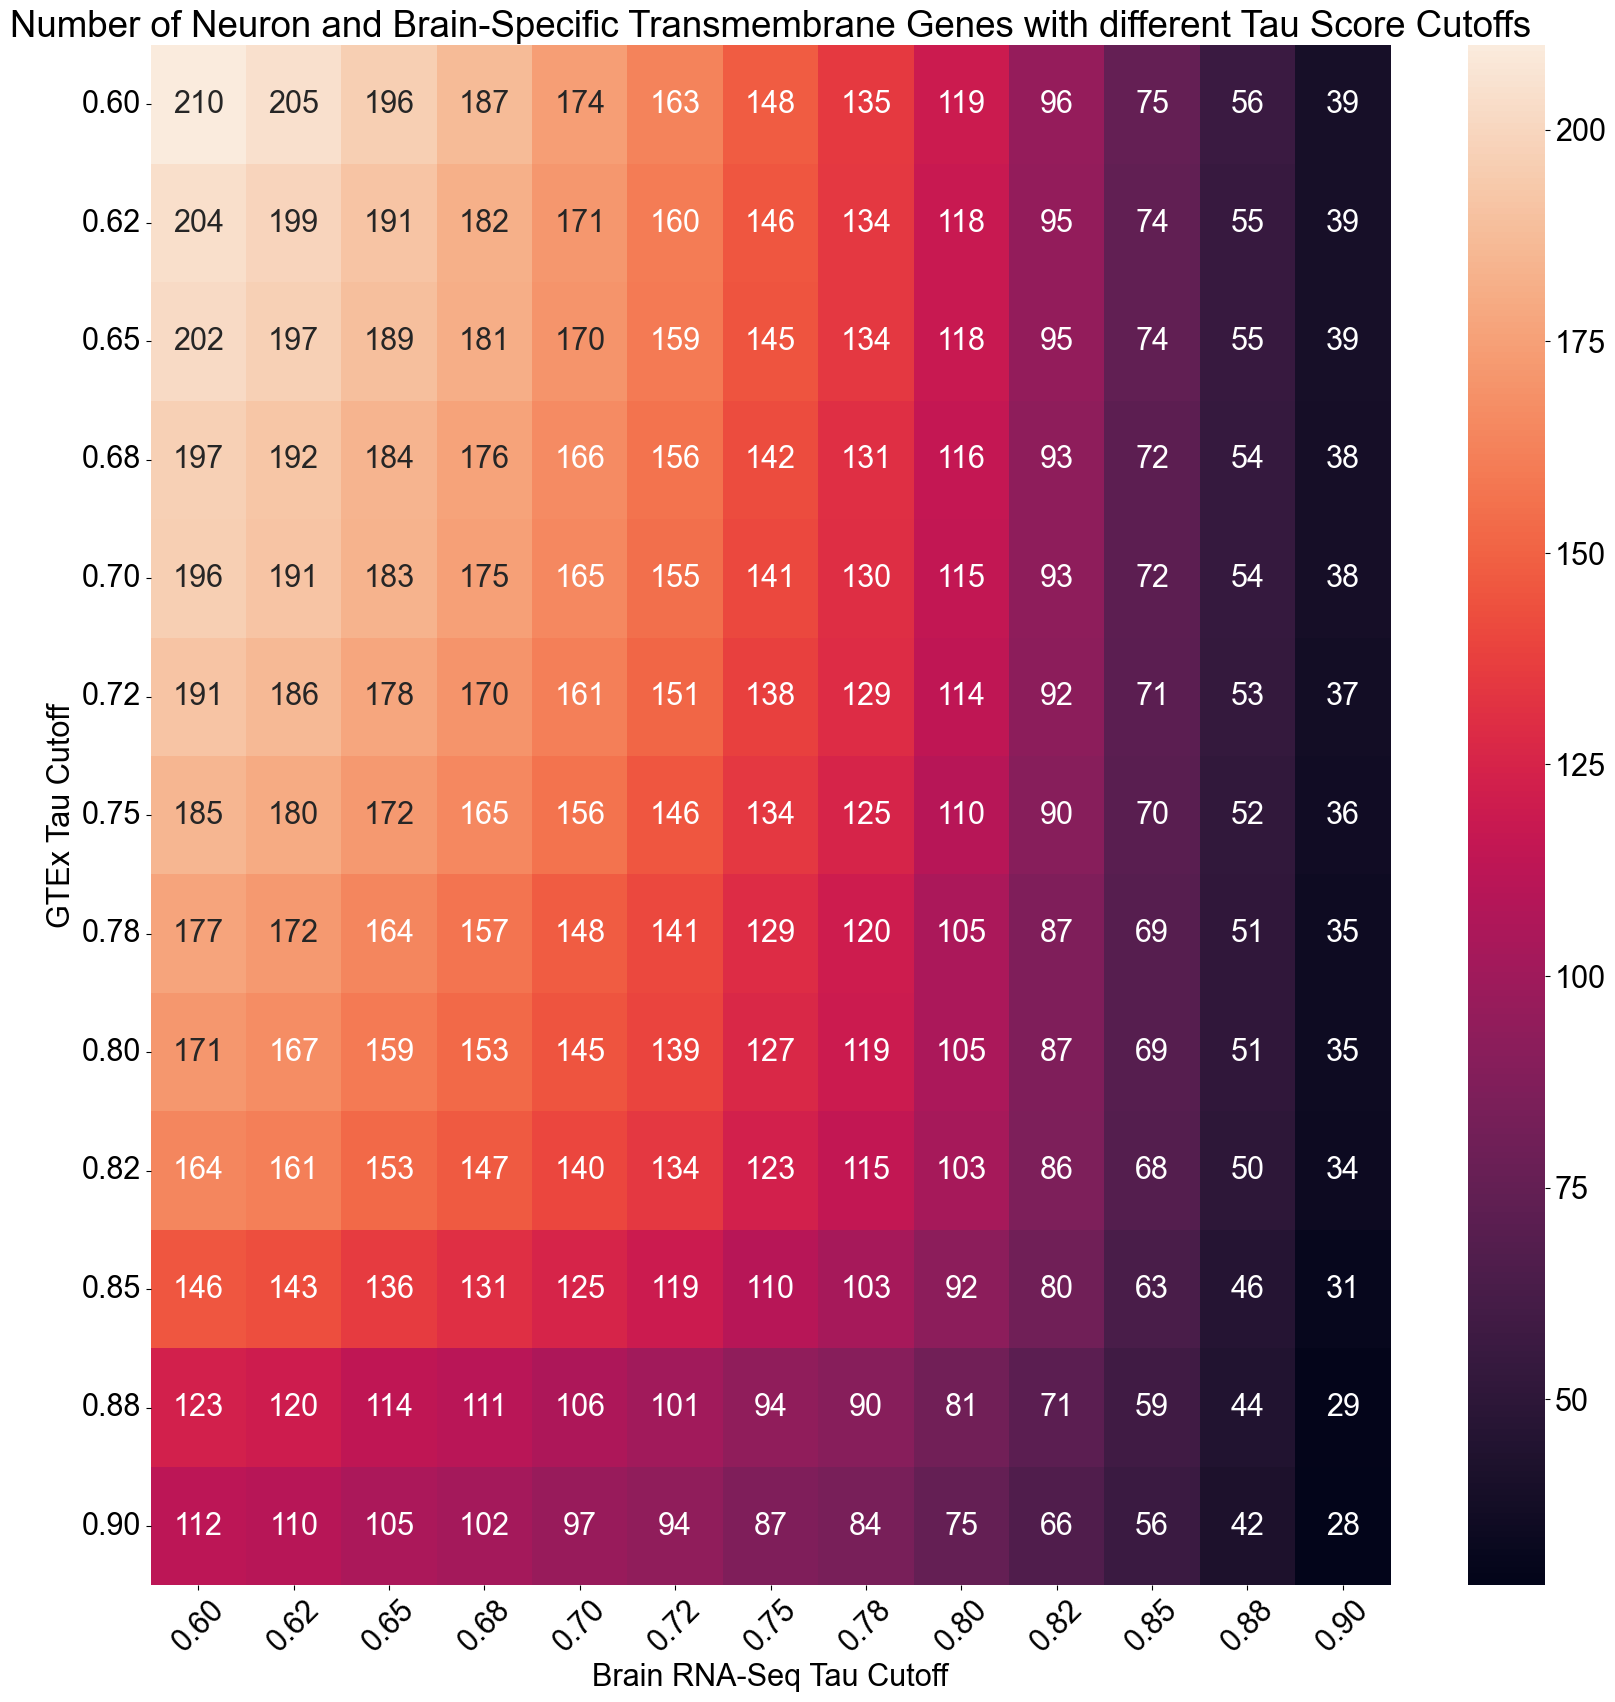

In [18]:
cutoff_num = 13
tau_cutoffs = np.linspace(0.6,0.9, num = cutoff_num)
cutoff_mat = np.zeros((tau_cutoffs.shape[0], tau_cutoffs.shape[0]), dtype = int)
for i, organ_cut in enumerate(tau_cutoffs):
    for j, cell_cut in enumerate(tau_cutoffs):
        all_data = get_specific_tau(all_data, 
                                 organ_tau_cutoff = organ_cut,
                                  cell_tau_cutoff = cell_cut,
                                 cluster_tau = False)
        cutoff_mat[i,j] = all_data['specific_tau'].shape[0]
        
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 22})
plt.figure(figsize= (20,20));
sns.heatmap(cutoff_mat, annot = True, fmt = 'd')
labels = ['{:.2f}'.format(c) for c in tau_cutoffs]
plt.xticks(np.arange(cutoff_num)+0.5,labels, rotation =45);
plt.yticks(np.arange(cutoff_num)+0.5, labels, rotation = 0);
plt.xlabel('Brain RNA-Seq Tau Cutoff');
plt.ylabel('GTEx Tau Cutoff');
plt.title('Number of Neuron and Brain-Specific Transmembrane Genes with different Tau Score Cutoffs');
plt.savefig('../figures/fig_s6_cutoff_heatmap.pdf', dpi = 600, transparent = True)

Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 64467.46it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!
Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 63183.29it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!
Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 64138.14it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!
Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 62213.34it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!


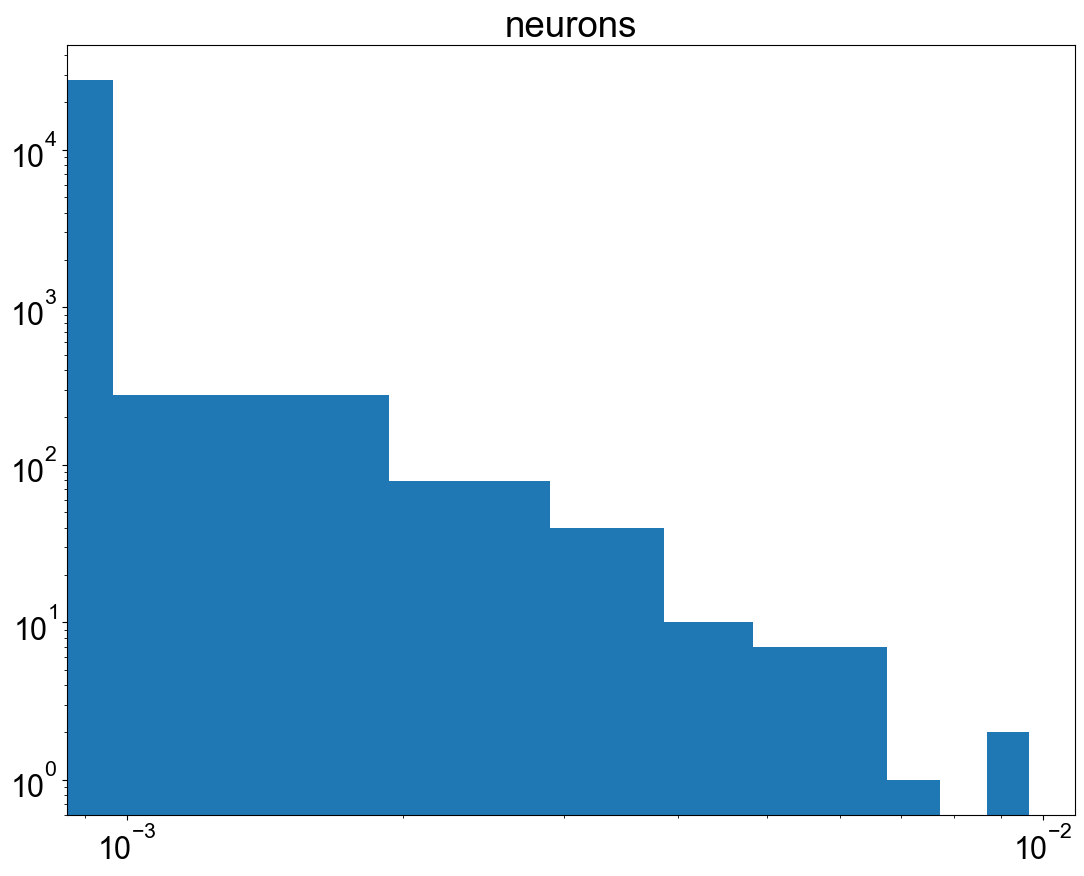

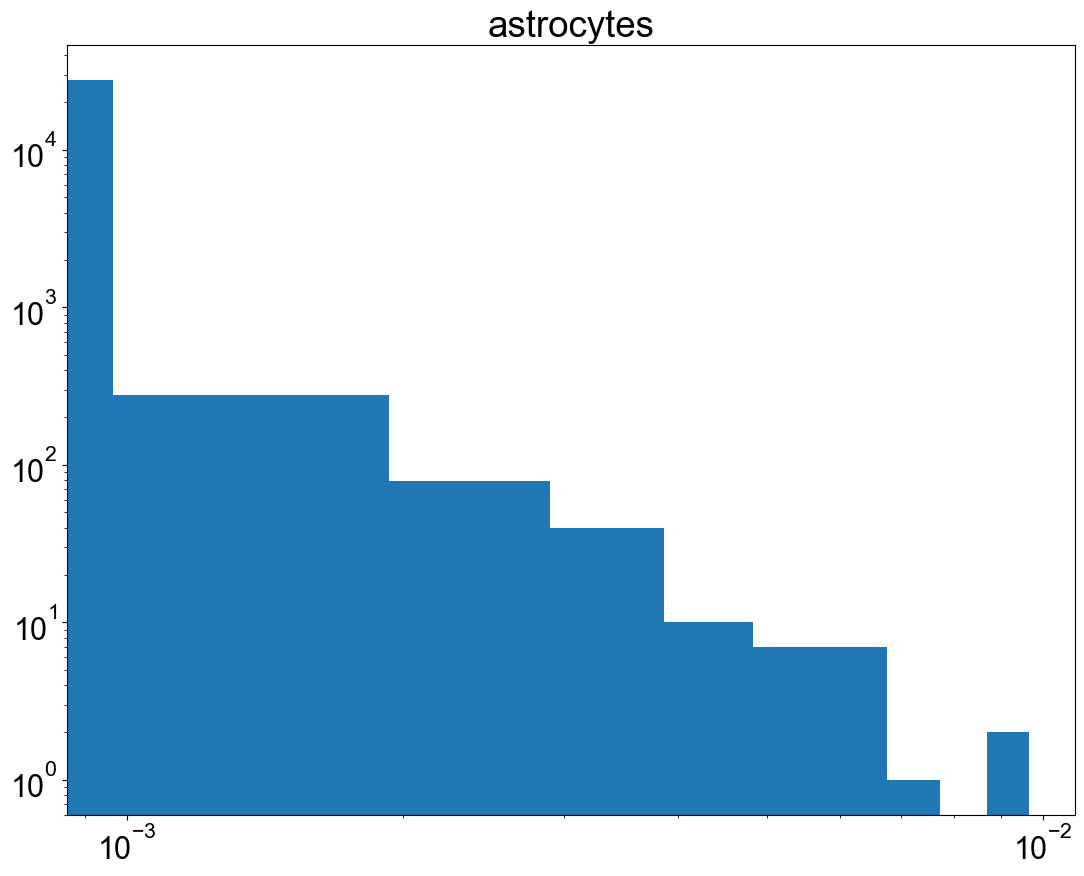

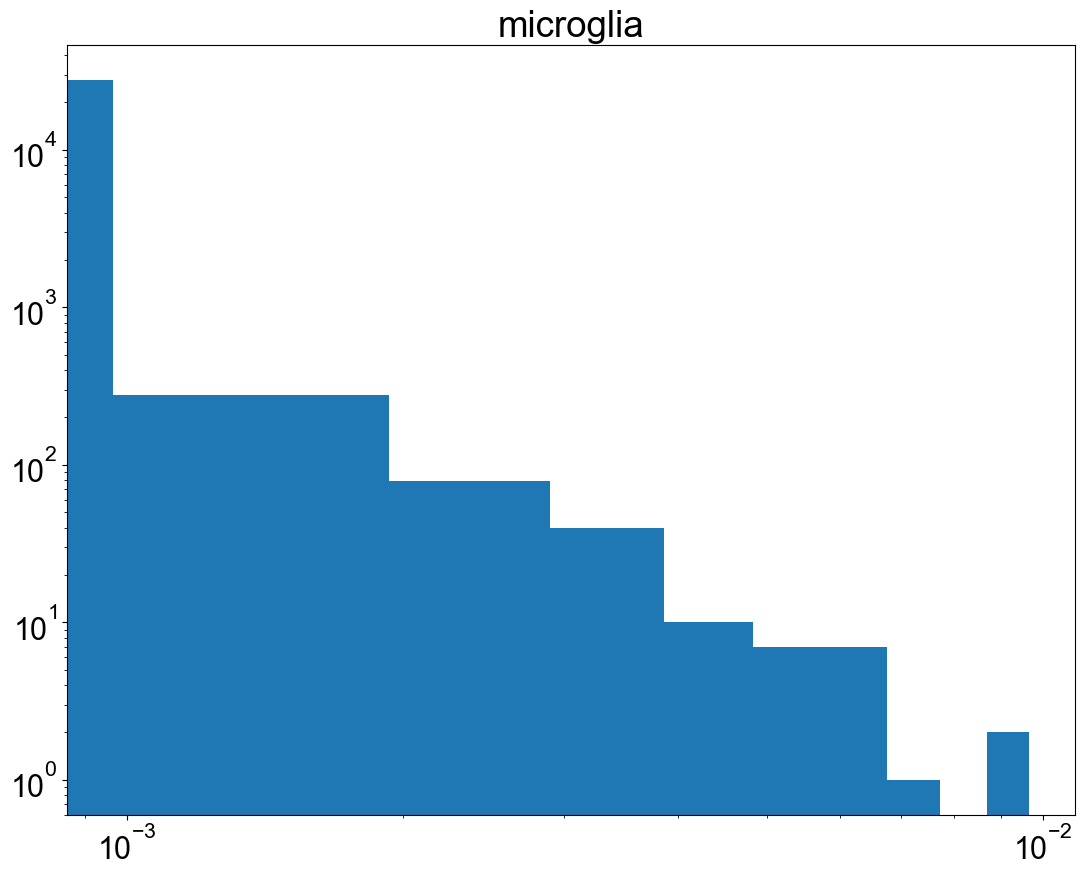

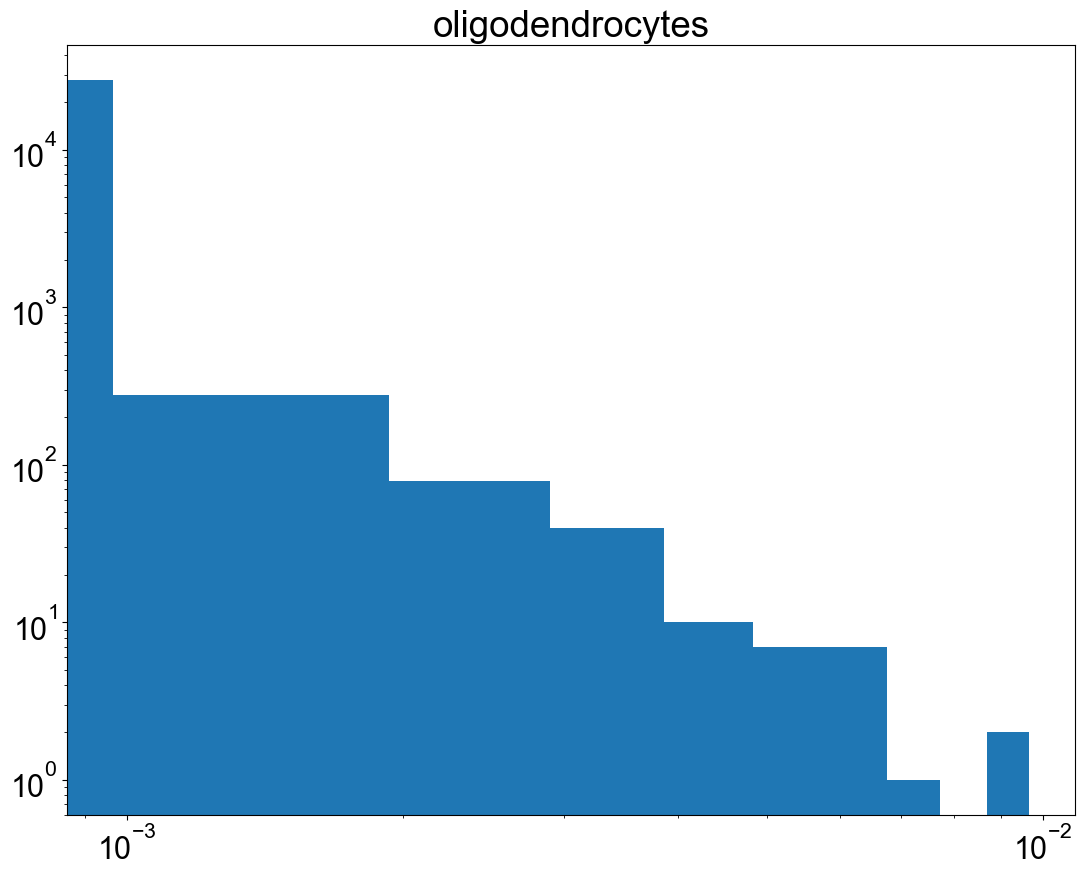

In [19]:

brain_cell_types = ['neurons', 'astrocytes', 'microglia', 'oligodendrocytes']
for cell_type in brain_cell_types:
    all_data = setup_datasets(brain_cell_type, organ_type)
    plt.figure(figsize = (13,10))
    plt.title(cell_type)
    plt.hist(all_data['scRNA_data']['attribution'])
    plt.xscale('log')
    plt.yscale('log')

In [20]:
all_data = setup_datasets('microglia', organ_type)
print('Microglia-specific genes by sCimilarity: {}'.format(sum(all_data['scRNA_data']['attribution']>0.001)))
all_data = get_final_list(all_data, exp_name = '20230730', topk= 20, use_scimilarity = True)
candidates = all_data['candidates']
print('Microglia-specific genes with TM domains by sCimilarity:', sum(candidates['Transmembrane']))

Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 63592.48it/s]
/Users/siddharthiyer/MIT Dropbox/Siddharth Iyer/DAT/Computational/extracellular-vesicle-markers/bin/import_surfacemarker_data.py:31: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!
Importing mass spectrometry data...
Done!
Microglia-specific genes by sCimilarity: 116
Microglia-specific genes with TM domains by sCimilarity: 30
